# DICOM Image Preprocessing Exploration

This notebook explores different preprocessing techniques for DICOM medical images.

## 1. Import Required Libraries

In [373]:
import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pydicom
from tqdm import tqdm

# Set matplotlib to display plots inline
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 4)

## 2. Load DICOM File

In [374]:
# Path to your DICOM file
dicom_file = r'R:\Radiotherapie - Physique Medicale\90 Encadrement etudiant\07EPITA\Etudiant Epita 2025\Alexandre Girold\TEST_AQUA\1.3.46.423632.420000.1761060608.3.dcm'

dicom_data = pydicom.dcmread(dicom_file)
image_array = dicom_data.pixel_array.astype(np.float32)
SAD = float(dicom_data.RadiationMachineSAD)  # in mm
SID = float(dicom_data.RTImageSID)  # in mm
scale_factor = SID / SAD  

print(f"Image shape: {image_array.shape}")
print(f"Min value: {image_array.min()}")
print(f"Max value: {image_array.max()}")

Image shape: (1024, 1024)
Min value: 25310.0
Max value: 65535.0


## 3. Display Original Image

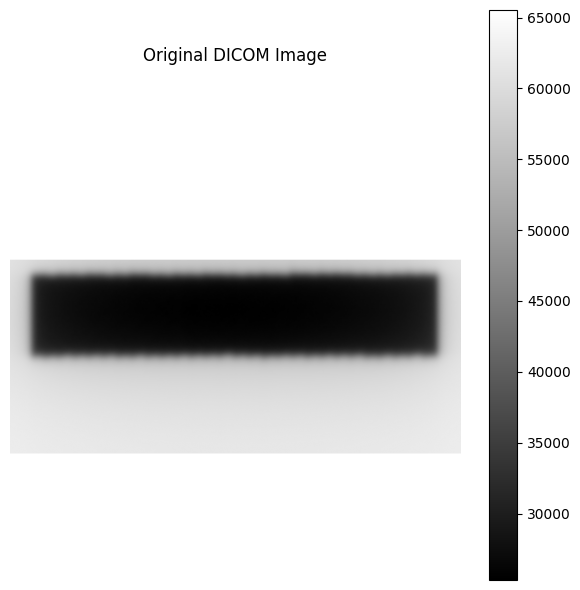

In [375]:
plt.figure(figsize=(6, 6))
plt.imshow(image_array, cmap='gray')
plt.title('Original DICOM Image')
plt.colorbar()
plt.axis('off')
plt.tight_layout()
plt.show()

## 4. Preprocessing Techniques

### 4.1 Normalization

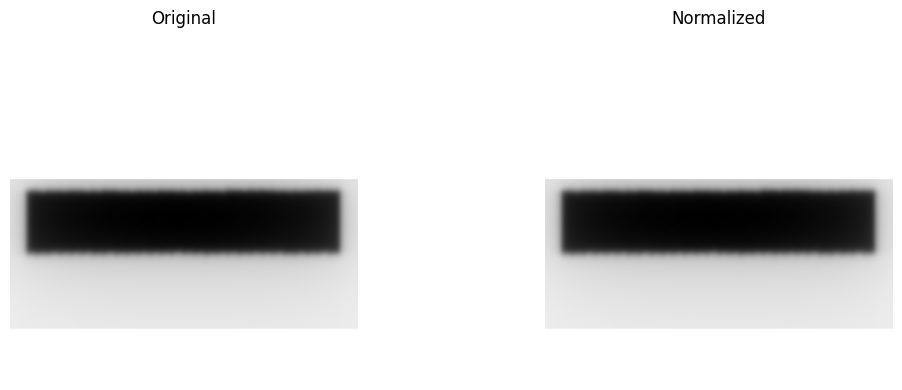

In [376]:
# Normalize image to 0-1 range
def normalize_image(image):
    min_val = image.min()
    max_val = image.max()
    normalized = (image - min_val) / (max_val - min_val)
    return normalized

normalized_img = normalize_image(image_array)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.imshow(image_array, cmap='gray')
plt.title('Original')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(normalized_img, cmap='gray')
plt.title('Normalized')
plt.axis('off')
plt.tight_layout()
plt.show()

### 4.2 Contrast Enhancement Techniques

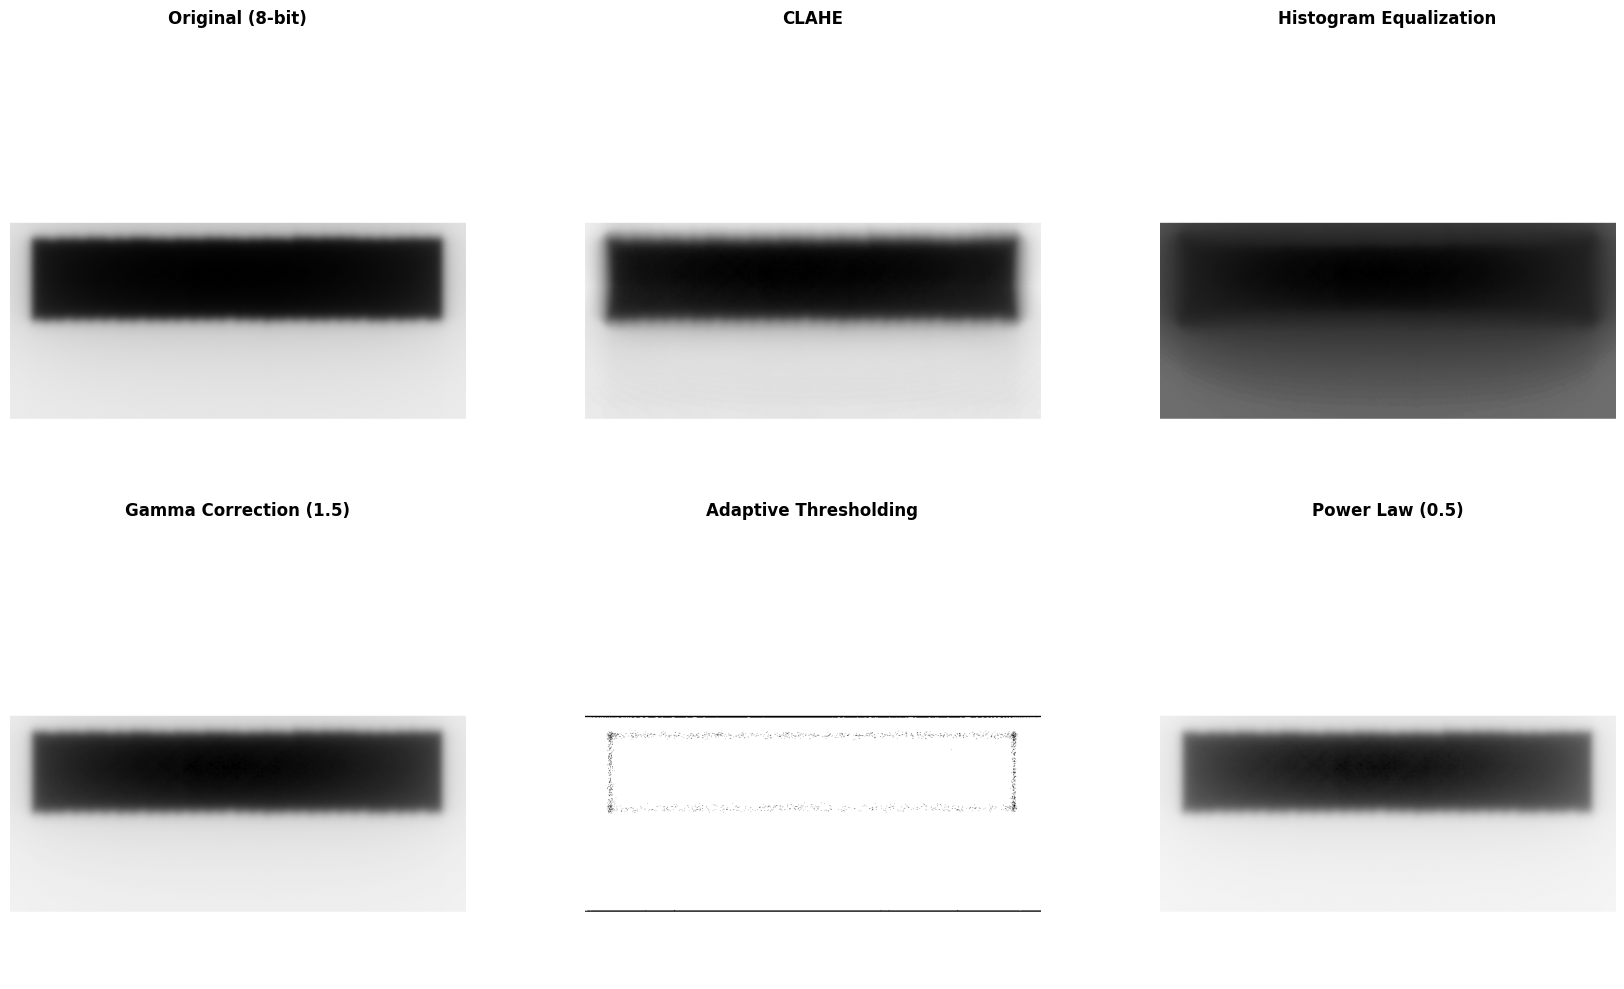


CONTRAST ENHANCEMENT METHODS

1. CLAHE: Best for local contrast improvement
   - Preserves details while enhancing contrast
   - Avoids over-amplification of noise

2. HISTOGRAM EQUALIZATION: Simple global contrast stretching
   - Can cause over-enhancement
   - Good for overall brightness distribution

3. GAMMA CORRECTION: Non-linear brightness adjustment
   - <1.0 darkens, >1.0 brightens
   - Preserves detail relationships

4. ADAPTIVE THRESHOLDING: Local binary conversion
   - Creates high contrast binary image
   - Good for edge detection preparation

5. POWER LAW: Aggressive non-linear transformation
   - Emphasizes bright and dark regions
   - Highlights edges naturally


In [377]:
# 1. CLAHE (Contrast Limited Adaptive Histogram Equalization)
img_8bit_for_contrast = cv2.normalize(normalized_img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
clahe_img = clahe.apply(img_8bit_for_contrast)

# 2. Histogram Equalization
hist_eq_img = cv2.equalizeHist(img_8bit_for_contrast)

# 3. Gamma Correction (brightening)
gamma = 1.5
inv_gamma = 1.0 / gamma
table = np.array([((i / 255.0) ** inv_gamma) * 255 for i in np.arange(0, 256)]).astype(np.uint8)
gamma_corrected = cv2.LUT(img_8bit_for_contrast, table)

# 4. Adaptive Thresholding (local contrast)
adaptive_thresh = cv2.adaptiveThreshold(img_8bit_for_contrast, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                         cv2.THRESH_BINARY, 11, 2)

# 5. Power Law Transformation (more aggressive gamma)
power_law = np.power(normalized_img, 0.5) * 255
power_law = power_law.astype(np.uint8)

# Display all contrast enhancement methods
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

axes[0, 0].imshow(img_8bit_for_contrast, cmap='gray')
axes[0, 0].set_title('Original (8-bit)', fontsize=12, fontweight='bold')
axes[0, 0].axis('off')

axes[0, 1].imshow(clahe_img, cmap='gray')
axes[0, 1].set_title('CLAHE', fontsize=12, fontweight='bold')
axes[0, 1].axis('off')

axes[0, 2].imshow(hist_eq_img, cmap='gray')
axes[0, 2].set_title('Histogram Equalization', fontsize=12, fontweight='bold')
axes[0, 2].axis('off')

axes[1, 0].imshow(gamma_corrected, cmap='gray')
axes[1, 0].set_title('Gamma Correction (1.5)', fontsize=12, fontweight='bold')
axes[1, 0].axis('off')

axes[1, 1].imshow(adaptive_thresh, cmap='gray')
axes[1, 1].set_title('Adaptive Thresholding', fontsize=12, fontweight='bold')
axes[1, 1].axis('off')

axes[1, 2].imshow(power_law, cmap='gray')
axes[1, 2].set_title('Power Law (0.5)', fontsize=12, fontweight='bold')
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("CONTRAST ENHANCEMENT METHODS")
print("="*60)
print("\n1. CLAHE: Best for local contrast improvement")
print("   - Preserves details while enhancing contrast")
print("   - Avoids over-amplification of noise")
print("\n2. HISTOGRAM EQUALIZATION: Simple global contrast stretching")
print("   - Can cause over-enhancement")
print("   - Good for overall brightness distribution")
print("\n3. GAMMA CORRECTION: Non-linear brightness adjustment")
print("   - <1.0 darkens, >1.0 brightens")
print("   - Preserves detail relationships")
print("\n4. ADAPTIVE THRESHOLDING: Local binary conversion")
print("   - Creates high contrast binary image")
print("   - Good for edge detection preparation")
print("\n5. POWER LAW: Aggressive non-linear transformation")
print("   - Emphasizes bright and dark regions")
print("   - Highlights edges naturally")
print("="*60)

### 4.2.1 Sharpening Techniques on CLAHE

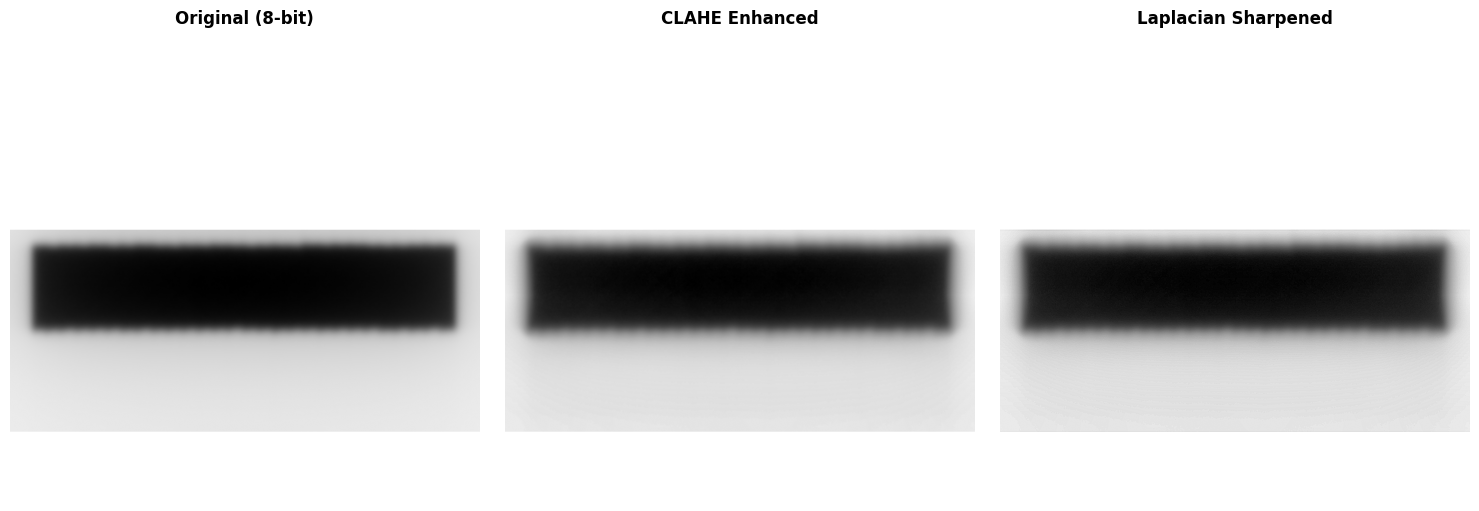

Pipeline: Normalization → CLAHE → Laplacian Sharpening


In [378]:
# Apply Laplacian Sharpening to CLAHE image

# Laplacian Sharpening
laplacian_kernel = np.array([[0, -1, 0],
                             [-1, 5, -1],
                             [0, -1, 0]], dtype=np.float32)
laplacian_sharpened = cv2.filter2D(clahe_img, -1, laplacian_kernel)
laplacian_sharpened = np.clip(laplacian_sharpened, 0, 255).astype(np.uint8)

# Display comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(img_8bit_for_contrast, cmap='gray')
axes[0].set_title('Original (8-bit)', fontsize=12, fontweight='bold')
axes[0].axis('off')

axes[1].imshow(clahe_img, cmap='gray')
axes[1].set_title('CLAHE Enhanced', fontsize=12, fontweight='bold')
axes[1].axis('off')

axes[2].imshow(laplacian_sharpened, cmap='gray')
axes[2].set_title('Laplacian Sharpened', fontsize=12, fontweight='bold')
axes[2].axis('off')

plt.tight_layout()
plt.show()

print("Pipeline: Normalization → CLAHE → Laplacian Sharpening")

### 4.2.2 Measure Black Regions (Leaf Bumps)

Pixel Spacing: 0.4 mm/pixel (X), 0.4 mm/pixel (Y)

BLACK REGIONS (LEAF BUMPS) MEASUREMENTS

Total number of black regions detected (after filtering): 1
Minimum area threshold: 500 pixels

Region   Height (px)    Height (mm)    Width (px)     Width (mm)     Area (px²)     Area (mm²)    
--------------------------------------------------------------------------------
1        170            68.00          904            361.60         147676         23628.16      
--------------------------------------------------------------------------------

Statistics at ISOCENTER (SAD = 1435.00 mm, Scaling Factor = 0.5399):
Average Height: 36.71 mm
Average Width: 195.24 mm
Average Area: 6887.94 mm²
Min Height: 36.71 mm
Min Width: 195.24 mm


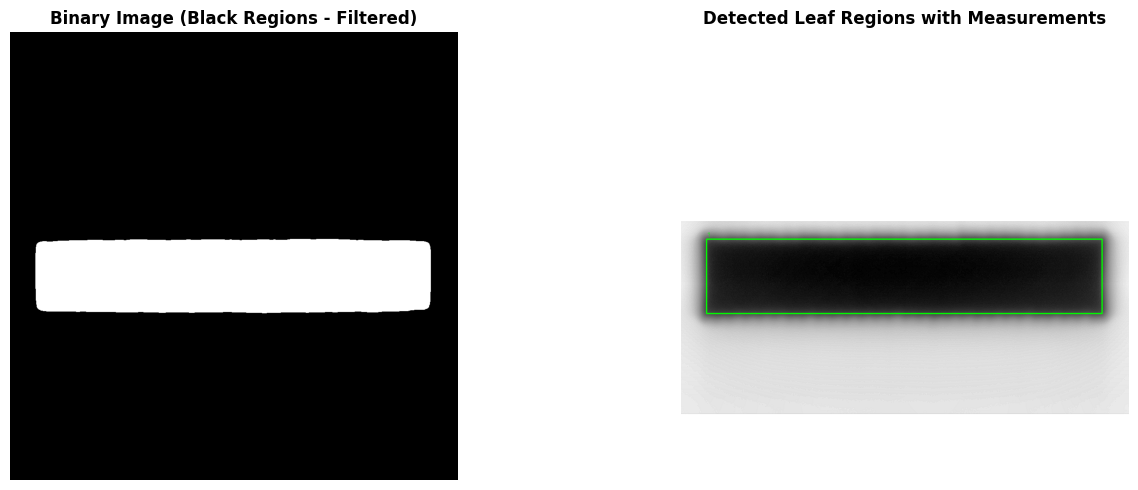

In [379]:
# Measure height and width of black regions in the Laplacian sharpened image
# Extract pixel spacing from DICOM metadata in our case it is 1px = 0.4mm
pixel_spacing = dicom_data.ImagePlanePixelSpacing
pixel_spacing_x = float(pixel_spacing[0])  # mm per pixel (X direction)
pixel_spacing_y = float(pixel_spacing[1])  # mm per pixel (Y direction)

print(f"Pixel Spacing: {pixel_spacing_x} mm/pixel (X), {pixel_spacing_y} mm/pixel (Y)")

# ============================================================================
# TOLERANCE PARAMETERS - Adjust these to control edge detection sensitivity
# ============================================================================
tolerance_threshold = 50      # Range: 50-150 (Lower = more sensitive, detects fainter edges)
tolerance_kernel_size = 5      # Range: 3-9 (Larger = more smoothing, fills gaps)
# ============================================================================

# Create binary image from Laplacian sharpened (black pixels are the edges/leaves)
# Use a higher threshold to avoid detecting tiny noise
"""
first arg : source image
second arg: threshold value -> the higher the value the less sensitive
third arg : 255 is black 
fourth arg: type of thresholding
"""
_, binary_image = cv2.threshold(img_8bit_for_contrast, tolerance_threshold, 255, cv2.THRESH_BINARY_INV)

# Apply morphological operations to clean up and connect regions
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (tolerance_kernel_size, tolerance_kernel_size))
binary_image = cv2.morphologyEx(binary_image, cv2.MORPH_CLOSE, kernel)
binary_image = cv2.morphologyEx(binary_image, cv2.MORPH_OPEN, kernel)

# Find contours of black regions (leaf bumps)
contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Filter out very small regions (noise) - keep only regions with area > 500 pixels
min_area = 500
contours = [c for c in contours if cv2.contourArea(c) > min_area]

print(f"\n" + "="*80)
print("BLACK REGIONS (LEAF BUMPS) MEASUREMENTS")
print("="*80)
print(f"\nTotal number of black regions detected (after filtering): {len(contours)}")
print(f"Minimum area threshold: {min_area} pixels")
print(f"\n{'Region':<8} {'Height (px)':<14} {'Height (mm)':<14} {'Width (px)':<14} {'Width (mm)':<14} {'Area (px²)':<14} {'Area (mm²)':<14}")
print("-" * 80)

heights_px = []
widths_px = []
areas_px = []

for i, contour in enumerate(contours):
    # Get bounding rectangle (in pixels)
    x, y, w, h = cv2.boundingRect(contour)
    area_px = cv2.contourArea(contour)
    
    # Convert to millimeters
    h_mm = h * pixel_spacing_y
    w_mm = w * pixel_spacing_x
    # print("HEREEEEEEE ->", pixel_spacing_x, pixel_spacing_y)
    area_mm2 = area_px * (pixel_spacing_x * pixel_spacing_y)
    
    heights_px.append(h)
    widths_px.append(w)
    areas_px.append(area_px)
    
    print(f"{i+1:<8} {h:<14} {h_mm:<14.2f} {w:<14} {w_mm:<14.2f} {area_px:<14.0f} {area_mm2:<14.2f}")

print("-" * 80)
if len(contours) > 0:
    # Calculate statistics in pixels
    avg_height_px = np.mean(heights_px)
    avg_width_px = np.mean(widths_px)
    avg_area_px = np.mean(areas_px)
    min_height_px = np.min(heights_px)
    max_height_px = np.max(heights_px)
    min_width_px = np.min(widths_px)
    max_width_px = np.max(widths_px)
    
    # Convert to millimeters (at image plane)
    avg_height_mm = avg_height_px * pixel_spacing_y
    avg_width_mm = avg_width_px * pixel_spacing_x
    avg_area_mm2 = avg_area_px * (pixel_spacing_x * pixel_spacing_y)
    min_height_mm = min_height_px * pixel_spacing_y
    max_height_mm = max_height_px * pixel_spacing_y
    min_width_mm = min_width_px * pixel_spacing_x
    max_width_mm = max_width_px * pixel_spacing_x
    
    # Extract geometric parameters for isocenter scaling
    rt_image_sid = float(dicom_data.RTImageSID)
    radiation_sad = float(dicom_data.RadiationMachineSAD)
    scaling_factor = radiation_sad / rt_image_sid
    
    # Convert to isocenter plane (scaled by SAD/SID)
    avg_height_iso = avg_height_mm * scaling_factor
    avg_width_iso = avg_width_mm * scaling_factor
    avg_area_iso = avg_area_mm2 * (scaling_factor ** 2)
    height_iso = min_height_mm * scaling_factor
    width_iso = min_width_mm * scaling_factor
    
    print(f"\nStatistics at ISOCENTER (SAD = {radiation_sad:.2f} mm, Scaling Factor = {scaling_factor:.4f}):")
    print(f"Average Height: {avg_height_iso:.2f} mm")
    print(f"Average Width: {avg_width_iso:.2f} mm")
    print(f"Average Area: {avg_area_iso:.2f} mm²")
    print(f"Min Height: {height_iso:.2f} mm")
    print(f"Min Width: {width_iso:.2f} mm")
else:
    print("\nNo regions detected! Try adjusting the threshold or minimum area.")
print("="*80)

# Visualize the regions with bounding boxes
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Show binary image
axes[0].imshow(binary_image, cmap='gray')
axes[0].set_title('Binary Image (Black Regions - Filtered)', fontsize=12, fontweight='bold')
axes[0].axis('off')

# Show image with bounding boxes drawn
image_with_boxes = cv2.cvtColor(laplacian_sharpened, cv2.COLOR_GRAY2BGR)
for i, contour in enumerate(contours):
    x, y, w, h = cv2.boundingRect(contour)
    cv2.rectangle(image_with_boxes, (x, y), (x + w, y + h), (0, 255, 0), 2)
    cv2.putText(image_with_boxes, str(i+1), (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

axes[1].imshow(image_with_boxes)
axes[1].set_title('Detected Leaf Regions with Measurements', fontsize=12, fontweight='bold')
axes[1].axis('off')

plt.tight_layout()
plt.show()

### 4.2.4 Jaw Positioning (Radiotherapy Coordinates)


In [380]:
# Extract RTImagePosition from DICOM metadata
# This defines the position of the top-left corner of the image in patient coordinates
rt_image_position = dicom_data.RTImagePosition
rt_image_pos_x = float(rt_image_position[0])  # mm from patient origin (X direction)
rt_image_pos_y = float(rt_image_position[1])  # mm from patient origin (Y direction)

print(f"RT Image Position (top-left corner):")
print(f"  X = {rt_image_pos_x} mm")
print(f"  Y = {rt_image_pos_y} mm")

RT Image Position (top-left corner):
  X = -205.03 mm
  Y = 205.03 mm


### 4.2.3 Extract DICOM Positioning Metadata

In [381]:
# Calculate jaw positioning (radiotherapy coordinates) for all detected regions
# In radiotherapy, jaws are reported as OPPOSING PAIRS that define field boundaries:
# - X-jaws (X1, X2): Control the vertical field edges (top and bottom)
# - Y-jaws (Y1, Y2): Control the horizontal field edges (left and right)
# Each jaw pair MUST be at different positions to define the radiation field

print("\n" + "="*80)
print("JAW POSITIONING - RADIOTHERAPY COORDINATES")
print("="*80)

if len(contours) > 0:
    print(f"\n{'Region':<8} {'Center X (px)':<16} {'Center Y (px)':<16} {'Center X (mm)':<16} {'Center Y (mm)':<16}")
    print("-" * 88)
    
    jaw_data_list = []
    
    for i, contour in enumerate(contours):
        x, y, w, h = cv2.boundingRect(contour)
        
        # Calculate center of this region (in image pixels)
        center_px_x = x + w / 2
        center_px_y = y + h / 2
        
        # Convert center to patient coordinate system (mm) using DICOM RTImagePosition
        center_mm_x = rt_image_pos_x + (center_px_x * pixel_spacing_x)
        center_mm_y = rt_image_pos_y + (center_px_y * pixel_spacing_y)
        
        # Calculate physical dimensions of the region
        width_mm = w * pixel_spacing_x
        height_mm = h * pixel_spacing_y
        
        # Calculate JAW PAIRS from bounding box edges
        # Y-jaws (left and right edges) - control horizontal field width
        jaw_y1 = center_mm_x - (width_mm / 2)   # Left jaw position
        jaw_y2 = center_mm_x + (width_mm / 2)   # Right jaw position
        
        # X-jaws (top and bottom edges) - control vertical field height
        jaw_x1 = center_mm_y - (height_mm / 2)  # Upper jaw position
        jaw_x2 = center_mm_y + (height_mm / 2)  # Lower jaw position
        
        jaw_data_list.append({
            'region': i + 1,
            'center_px_x': center_px_x,
            'center_px_y': center_px_y,
            'center_mm_x': center_mm_x,
            'center_mm_y': center_mm_y,
            'width_mm': width_mm,
            'height_mm': height_mm,
            'jaw_x1': jaw_x1,  # Upper jaw
            'jaw_x2': jaw_x2,  # Lower jaw
            'jaw_y1': jaw_y1,  # Left jaw
            'jaw_y2': jaw_y2   # Right jaw
        })
        
        print(f"{i+1:<8} {center_px_x:<16.2f} {center_px_y:<16.2f} {center_mm_x:<16.2f} {center_mm_y:<16.2f}")
    
    print("-" * 88)
    
    # Display jaw coordinates table
    print(f"\n{'Region':<8} {'Jaw X1 (mm)':<14} {'Jaw X2 (mm)':<14} {'Jaw Y1 (mm)':<14} {'Jaw Y2 (mm)':<14} {'Width (mm)':<12} {'Height (mm)':<12}")
    print("-" * 96)
    
    for data in jaw_data_list:
        print(f"{data['region']:<8} {data['jaw_x1']:<14.2f} {data['jaw_x2']:<14.2f} "
              f"{data['jaw_y1']:<14.2f} {data['jaw_y2']:<14.2f} {data['width_mm']:<12.2f} {data['height_mm']:<12.2f}")
    
    print("-" * 96)
    
    # Find extreme jaw positions
    leftmost_region = min(jaw_data_list, key=lambda item: item['jaw_y1'])
    rightmost_region = max(jaw_data_list, key=lambda item: item['jaw_y2'])
    
    print(f"\n" + "="*80)
    print("KEY JAW POSITIONS")
    print("="*80)
    
    print(f"\nLEFTMOST EDGE (Minimum Jaw Y1):")
    print(f"  Region #: {leftmost_region['region']}")
    print(f"  Jaw Y1 (left edge): {leftmost_region['jaw_y1']:.2f} mm")
    print(f"  Jaw Y2 (right edge): {leftmost_region['jaw_y2']:.2f} mm")
    print(f"  Center (mm): X={leftmost_region['center_mm_x']:.2f}, Y={leftmost_region['center_mm_y']:.2f}")
    
    print(f"\nRIGHTMOST EDGE (Maximum Jaw Y2):")
    print(f"  Region #: {rightmost_region['region']}")
    print(f"  Jaw Y1 (left edge): {rightmost_region['jaw_y1']:.2f} mm")
    print(f"  Jaw Y2 (right edge): {rightmost_region['jaw_y2']:.2f} mm")
    print(f"  Center (mm): X={rightmost_region['center_mm_x']:.2f}, Y={rightmost_region['center_mm_y']:.2f}")
    
    # Calculate jaw spans across all regions
    jaw_y_span = rightmost_region['jaw_y2'] - leftmost_region['jaw_y1']
    jaw_x_span = max(item['jaw_x2'] for item in jaw_data_list) - min(item['jaw_x1'] for item in jaw_data_list)
    
    print(f"\nJAW SPANS ACROSS ALL REGIONS:")
    print(f"  Y jaw span (left-right): {jaw_y_span:.2f} mm")
    print(f"  X jaw span (top-bottom): {jaw_x_span:.2f} mm")
    
else:
    print("\nNo regions detected! Cannot calculate jaw positions.")

print("="*80)



JAW POSITIONING - RADIOTHERAPY COORDINATES

Region   Center X (px)    Center Y (px)    Center X (mm)    Center Y (mm)   
----------------------------------------------------------------------------------------
1        510.00           558.00           -1.03            428.23          
----------------------------------------------------------------------------------------

Region   Jaw X1 (mm)    Jaw X2 (mm)    Jaw Y1 (mm)    Jaw Y2 (mm)    Width (mm)   Height (mm) 
------------------------------------------------------------------------------------------------
1        394.23         462.23         -181.83        179.77         361.60       68.00       
------------------------------------------------------------------------------------------------

KEY JAW POSITIONS

LEFTMOST EDGE (Minimum Jaw Y1):
  Region #: 1
  Jaw Y1 (left edge): -181.83 mm
  Jaw Y2 (right edge): 179.77 mm
  Center (mm): X=-1.03, Y=428.23

RIGHTMOST EDGE (Maximum Jaw Y2):
  Region #: 1
  Jaw Y1 (left edge): -18

In [382]:
# Project jaw measurements back to isocenter plane (SAD)
# Geometric scaling factor: SAD/SID

# Extract geometric parameters from DICOM
rt_image_sid = float(dicom_data.RTImageSID)  # Source to Image Distance
radiation_sad = float(dicom_data.RadiationMachineSAD)  # Source to Axis Distance (isocenter)

# Calculate scaling factor
scaling_factor = radiation_sad / rt_image_sid

print(f"Geometric Scaling Parameters:")
print(f"  RT Image SID: {rt_image_sid:.2f} mm (image plane distance)")
print(f"  Radiation SAD: {radiation_sad:.2f} mm (isocenter distance)")
print(f"  Scaling Factor (SAD/SID): {scaling_factor:.4f}")

print("\n" + "="*80)
print("ISOCENTER-CORRECTED JAW POSITIONS (SAD PLANE)")
print("="*80)

if len(contours) > 0:
    # Display isocenter-corrected jaw coordinates
    print(f"\n{'Region':<8} {'Jaw X1 (mm)':<14} {'Jaw X2 (mm)':<14} {'Jaw Y1 (mm)':<14} {'Jaw Y2 (mm)':<14} {'Width (mm)':<12} {'Height (mm)':<12}")
    print("-" * 96)
    
    jaw_data_isocenter = []
    
    for data in jaw_data_list:
        # Scale positions to isocenter plane
        jaw_x1_iso = data['jaw_x1'] * scaling_factor
        jaw_x2_iso = data['jaw_x2'] * scaling_factor
        jaw_y1_iso = data['jaw_y1'] * scaling_factor
        jaw_y2_iso = data['jaw_y2'] * scaling_factor
        
        # Scale dimensions
        width_iso = data['width_mm'] * scaling_factor
        height_iso = data['height_mm'] * scaling_factor
        
        jaw_data_isocenter.append({
            'region': data['region'],
            'jaw_x1': jaw_x1_iso,
            'jaw_x2': jaw_x2_iso,
            'jaw_y1': jaw_y1_iso,
            'jaw_y2': jaw_y2_iso,
            'width': width_iso,
            'height': height_iso
        })
        
        print(f"{data['region']:<8} {jaw_x1_iso:<14.2f} {jaw_x2_iso:<14.2f} "
              f"{jaw_y1_iso:<14.2f} {jaw_y2_iso:<14.2f} {width_iso:<12.2f} {height_iso:<12.2f}")
    
    print("-" * 96)
    
    # Find extreme jaw positions at isocenter
    leftmost_iso = min(jaw_data_isocenter, key=lambda item: item['jaw_y1'])
    rightmost_iso = max(jaw_data_isocenter, key=lambda item: item['jaw_y2'])
    
    print(f"\n" + "="*80)
    print("KEY JAW POSITIONS AT ISOCENTER")
    print("="*80)
    
    print(f"\nLEFTMOST EDGE (Minimum Jaw Y1):")
    print(f"  Region #: {leftmost_iso['region']}")
    print(f"  Jaw Y1 (left edge): {leftmost_iso['jaw_y1']:.2f} mm")
    print(f"  Jaw Y2 (right edge): {leftmost_iso['jaw_y2']:.2f} mm")
    
    print(f"\nRIGHTMOST EDGE (Maximum Jaw Y2):")
    print(f"  Region #: {rightmost_iso['region']}")
    print(f"  Jaw Y1 (left edge): {rightmost_iso['jaw_y1']:.2f} mm")
    print(f"  Jaw Y2 (right edge): {rightmost_iso['jaw_y2']:.2f} mm")
    
    # Calculate jaw spans at isocenter
    jaw_y_span_iso = rightmost_iso['jaw_y2'] - leftmost_iso['jaw_y1']
    jaw_x_span_iso = max(item['jaw_x2'] for item in jaw_data_isocenter) - min(item['jaw_x1'] for item in jaw_data_isocenter)
    
    print(f"\nJAW SPANS AT ISOCENTER:")
    print(f"  Y jaw span (left-right): {jaw_y_span_iso:.2f} mm")
    print(f"  X jaw span (top-bottom): {jaw_x_span_iso:.2f} mm")
    
else:
    print("\nNo regions detected! Cannot calculate jaw positions.")

print("="*80)

Geometric Scaling Parameters:
  RT Image SID: 2657.80 mm (image plane distance)
  Radiation SAD: 1435.00 mm (isocenter distance)
  Scaling Factor (SAD/SID): 0.5399

ISOCENTER-CORRECTED JAW POSITIONS (SAD PLANE)

Region   Jaw X1 (mm)    Jaw X2 (mm)    Jaw Y1 (mm)    Jaw Y2 (mm)    Width (mm)   Height (mm) 
------------------------------------------------------------------------------------------------
1        212.85         249.57         -98.17         97.06          195.24       36.71       
------------------------------------------------------------------------------------------------

KEY JAW POSITIONS AT ISOCENTER

LEFTMOST EDGE (Minimum Jaw Y1):
  Region #: 1
  Jaw Y1 (left edge): -98.17 mm
  Jaw Y2 (right edge): 97.06 mm

RIGHTMOST EDGE (Maximum Jaw Y2):
  Region #: 1
  Jaw Y1 (left edge): -98.17 mm
  Jaw Y2 (right edge): 97.06 mm

JAW SPANS AT ISOCENTER:
  Y jaw span (left-right): 195.24 mm
  X jaw span (top-bottom): 36.71 mm


### 4.2.5 Isocenter-Corrected Jaw Positions (SAD Plane)


INDIVIDUAL LEAF DETECTION

Leaf Width:
  At Isocenter (SAD): 6.97 mm
  At Image Plane (SID): 12.91 mm
  In Pixels: 32.29 px

Field Analysis:
  Field Width (pixels): 904.00 px
  Number of Leaves: 28

Leaf     X (px)       Top Y (px)   Bottom Y (px) Top Y (mm)     Bottom Y (mm) 
----------------------------------------------------------------------------------------
1        74.1         478          638          213.93         248.49        
2        106.4        477          638          213.72         248.49        
3        138.7        476          639          213.50         248.70        
4        171.0        475          639          213.28         248.70        
5        203.3        475          639          213.28         248.70        
6        235.6        475          640          213.28         248.92        
7        267.9        474          640          213.07         248.92        
8        300.1        474          640          213.07         248.92        
9       

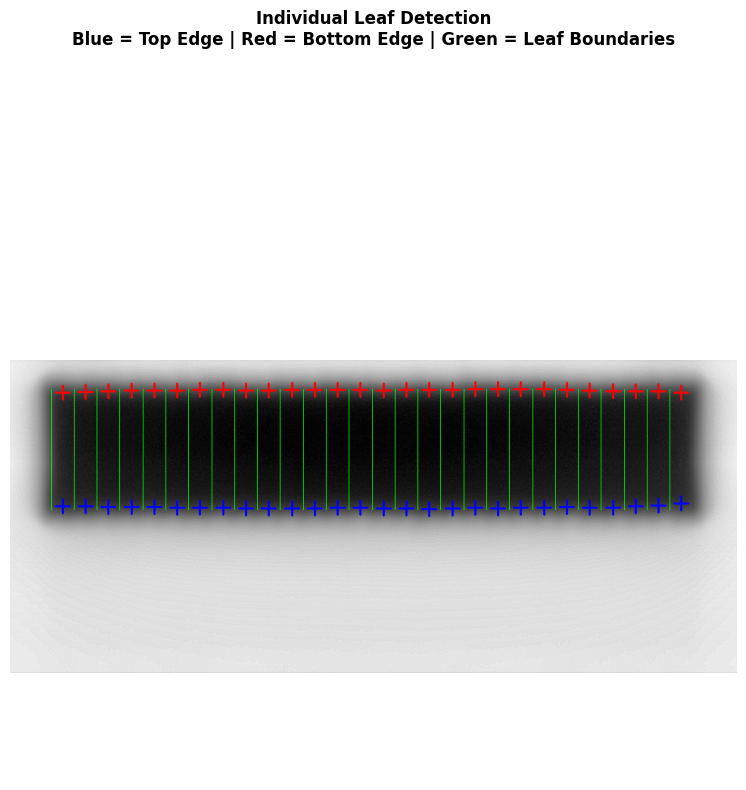

In [383]:
# Individual Leaf Detection
# Each MLC leaf is 5mm wide at isocenter
# We'll divide the field into leaf columns and find the top/bottom edges of each leaf

# ============================================================================
# CONFIGURATION
# ============================================================================
leaves = True  # Set to False to skip this functionality

# TOLERANCE INHERITED FROM SECTION 4.2.2:
# The leaf edge detection uses the binary_image created above with:
#   - tolerance_threshold = 100 (adjust in section 4.2.2 to change sensitivity)
#   - tolerance_kernel_size = 5 (adjust in section 4.2.2 to change smoothing)
# ============================================================================

if leaves and len(contours) > 0:
    print("\n" + "="*80)
    print("INDIVIDUAL LEAF DETECTION")
    print("="*80)
    
    # Leaf width specifications
    num_leaves = 28  # Fixed number of leaves
    
    # Find the overall field boundaries from all detected regions
    all_x_min = min([cv2.boundingRect(c)[0] for c in contours])
    all_x_max = max([cv2.boundingRect(c)[0] + cv2.boundingRect(c)[2] for c in contours])
    all_y_min = min([cv2.boundingRect(c)[1] for c in contours])
    all_y_max = max([cv2.boundingRect(c)[1] + cv2.boundingRect(c)[3] for c in contours])
    
    field_width_pixels = all_x_max - all_x_min
    leaf_width_pixels = field_width_pixels / num_leaves  # Calculate leaf width from field and number of leaves
    
    # Calculate actual leaf width in mm
    leaf_width_image_plane = leaf_width_pixels * pixel_spacing_x  # mm at image plane
    leaf_width_iso = leaf_width_image_plane * scaling_factor  # mm at isocenter
    
    print(f"\nLeaf Width:")
    print(f"  At Isocenter (SAD): {leaf_width_iso:.2f} mm")
    print(f"  At Image Plane (SID): {leaf_width_image_plane:.2f} mm")
    print(f"  In Pixels: {leaf_width_pixels:.2f} px")
    
    print(f"\nField Analysis:")
    print(f"  Field Width (pixels): {field_width_pixels:.2f} px")
    print(f"  Number of Leaves: {num_leaves}")
    
    # Create visualization image
    leaf_detection_image = cv2.cvtColor(laplacian_sharpened, cv2.COLOR_GRAY2BGR)
    
    # Store leaf edge positions
    leaf_edges = []
    
    # Process each leaf column
    print(f"\n{'Leaf':<8} {'X (px)':<12} {'Top Y (px)':<12} {'Bottom Y (px)':<12} {'Top Y (mm)':<14} {'Bottom Y (mm)':<14}")
    print("-" * 88)
    
    for leaf_idx in range(num_leaves):
        # Calculate the X position for this leaf (center of leaf column)
        leaf_x_center = all_x_min + (leaf_idx + 0.5) * leaf_width_pixels
        leaf_x_start = int(all_x_min + leaf_idx * leaf_width_pixels)
        leaf_x_end = int(all_x_min + (leaf_idx + 1) * leaf_width_pixels)
        
        # Extract the vertical column for this leaf from the binary image
        leaf_column = binary_image[all_y_min:all_y_max, leaf_x_start:leaf_x_end]
        
        # Find the topmost and bottommost black pixels in this column
        black_pixels = np.where(leaf_column > 0)
        
        if len(black_pixels[0]) > 0:
            # Get the highest (min Y) and lowest (max Y) black pixels
            top_y_relative = np.min(black_pixels[0])
            bottom_y_relative = np.max(black_pixels[0])
            
            # Convert to absolute image coordinates
            top_y_absolute = all_y_min + top_y_relative
            bottom_y_absolute = all_y_min + bottom_y_relative
            
            # Convert to mm coordinates (patient reference frame)
            top_y_mm = rt_image_pos_y + (top_y_absolute * pixel_spacing_y)
            bottom_y_mm = rt_image_pos_y + (bottom_y_absolute * pixel_spacing_y)
            
            # Convert to isocenter coordinates
            top_y_iso = top_y_mm * scaling_factor
            bottom_y_iso = bottom_y_mm * scaling_factor
            
            leaf_edges.append({
                'leaf': leaf_idx + 1,
                'x_px': leaf_x_center,
                'top_y_px': top_y_absolute,
                'bottom_y_px': bottom_y_absolute,
                'top_y_iso': top_y_iso,
                'bottom_y_iso': bottom_y_iso
            })
            
            print(f"{leaf_idx + 1:<8} {leaf_x_center:<12.1f} {top_y_absolute:<12} {bottom_y_absolute:<12} {top_y_iso:<14.2f} {bottom_y_iso:<14.2f}")
            
            # Draw crosses at top and bottom positions
            cross_size = 10
            cross_color_top = (255, 0, 0)     # Blue for top
            cross_color_bottom = (0, 0, 255)  # Red for bottom
            
            # Top cross
            cv2.line(leaf_detection_image, 
                    (int(leaf_x_center) - cross_size, top_y_absolute), 
                    (int(leaf_x_center) + cross_size, top_y_absolute), 
                    cross_color_top, 2)
            cv2.line(leaf_detection_image, 
                    (int(leaf_x_center), top_y_absolute - cross_size), 
                    (int(leaf_x_center), top_y_absolute + cross_size), 
                    cross_color_top, 2)
            
            # Bottom cross
            cv2.line(leaf_detection_image, 
                    (int(leaf_x_center) - cross_size, bottom_y_absolute), 
                    (int(leaf_x_center) + cross_size, bottom_y_absolute), 
                    cross_color_bottom, 2)
            cv2.line(leaf_detection_image, 
                    (int(leaf_x_center), bottom_y_absolute - cross_size), 
                    (int(leaf_x_center), bottom_y_absolute + cross_size), 
                    cross_color_bottom, 2)
            
            # Draw vertical line to show leaf column
            cv2.line(leaf_detection_image,
                    (leaf_x_start, all_y_min),
                    (leaf_x_start, all_y_max),
                    (0, 255, 0), 1)
    
    print("-" * 88)
    
    # Calculate middle of the field
    if len(leaf_edges) > 0:
        middle_leaf_idx = len(leaf_edges) // 2
        middle_leaf = leaf_edges[middle_leaf_idx]
        
        print(f"\nMIDDLE OF FIELD:")
        print(f"  Middle Leaf Number: {middle_leaf['leaf']}")
        print(f"  X Position (pixels): {middle_leaf['x_px']:.1f}")
        print(f"  X Position (mm at image plane): {rt_image_pos_x + (middle_leaf['x_px'] * pixel_spacing_x):.2f}")
        print(f"  X Position (mm at isocenter): {(rt_image_pos_x + (middle_leaf['x_px'] * pixel_spacing_x)) * scaling_factor:.2f}")
    
    # Display the leaf detection image
    plt.figure(figsize=(12, 8))
    plt.imshow(leaf_detection_image)
    plt.title('Individual Leaf Detection\nBlue = Top Edge | Red = Bottom Edge | Green = Leaf Boundaries', 
             fontsize=12, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    print("="*80)
    
elif not leaves:
    print("\n" + "="*80)
    print("LEAF DETECTION SKIPPED (leaves=False)")
    print("="*80)
else:
    print("\n" + "="*80)
    print("LEAF DETECTION: No contours detected")
    print("="*80)

### 4.2.6 Individual Leaf Detection and Marking